# Revenue forecast as the foundation for dynamic pricing**

### Goal : Using Historical data of an Online Pharmacy to predict the revenue.


Dataset Source: 
https://www.data-mining-cup.com/reviews/dmc-2017/

Dataset Info:

- Attributes that change with time: train.csv
- Attributes that do not change with time: items.csv

Attributes of train.csv (11 columns):

                                           
 Index |Column           | Dtype     
-------| ----------------|----  
 0     | lineID          | int64           
 1     | day             | int64          
 2     | pid             | int64           
 3     | adFlag          | int64           
 4     | availability    | int64           
 5     | competitorPrice | float64         
 6     | click           | int64           
 7     | basket          | int64           
 8     | order           | int64           
 9     | price           | float64         
 10    | revenue         | float64         

 
 Attributes of items.csv (11 columns):


  Index |Column          | Dtype  
-------| ----------------|----  
 0     | pid             | int64  
 1     | manufacturer    | int64  
 2     | group           | object  
 3     | content         | object  
 4     | unit            | object  
 5     | pharmForm       | object
 6     | genericProduct  | int64  
 7     | salesIndex      | int64  
 8     | category        | float64  
 9     | campaignIndex   | object
 10    | rrp             | float64

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.impute import KNNImputer

In [ ]:
# from google.colab import drive
# import numpy as np
# drive.mount("/content/drive")

# Import the dataset

In [ ]:
# train_df = pd.read_csv('/content/drive/MyDrive/602_Project/train.csv', sep="|")
# items_df = pd.read_csv('/content/drive/MyDrive/602_Project/items.csv', sep="|")

In [ ]:
train_df = pd.read_csv('Dataset.csv')
items_df = pd.read_csv('items.csv', sep="|")

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661445 entries, 0 to 661444
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   lineID           661445 non-null  int64  
 1   day              661445 non-null  int64  
 2   pid              661445 non-null  int64  
 3   adFlag           661445 non-null  int64  
 4   availability     661445 non-null  int64  
 5   competitorPrice  638140 non-null  float64
 6   click            661445 non-null  int64  
 7   basket           661445 non-null  int64  
 8   order            661445 non-null  int64  
 9   price            661445 non-null  float64
 10  revenue          661445 non-null  float64
dtypes: float64(3), int64(8)
memory usage: 55.5 MB


In [ ]:
train_df.head(3)

,lineID,day,pid,adFlag,availability,competitorPrice,click,basket,order,price,revenue
0,1,1,6570,0,2,14.60,1,0,0,16.89,0.0
1,2,1,14922,1,1,8.57,0,1,0,8.75,0.0
2,3,1,16382,0,1,14.77,0,1,0,16.06,0.0


In [ ]:
train_df.shape

(661445, 11)

In [ ]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22035 entries, 0 to 22034
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             22035 non-null  int64  
 1   manufacturer    22035 non-null  int64  
 2   group           22035 non-null  object 
 3   content         22035 non-null  object 
 4   unit            22035 non-null  object 
 5   pharmForm       19708 non-null  object 
 6   genericProduct  22035 non-null  int64  
 7   salesIndex      22035 non-null  int64  
 8   category        17408 non-null  float64
 9   campaignIndex   1338 non-null   object 
 10  rrp             22035 non-null  float64
dtypes: float64(2), int64(4), object(5)
memory usage: 1.8+ MB


In [ ]:
items_df.shape

(22035, 11)

In [ ]:
items_df.head(3)

,pid,manufacturer,group,content,unit,pharmForm,genericProduct,salesIndex,category,campaignIndex,rrp
0,1,1,2FOI,80,ST,TAB,0,40,NaN,NaN,10.89
1,2,1,2FOI,80,ST,Tab,0,40,NaN,NaN,10.89
2,3,1,2FOI,10,G,GLO,0,40,NaN,NaN,16.45


In [ ]:
train_df = train_df.merge(items_df, on='pid',how='left')

In [ ]:
train_df.head().T

,0,1,2,3,4
lineID,1,2,3,4,5
day,1,1,1,1,1
pid,6570,14922,16382,1145,3394
adFlag,0,1,0,1,0
availability,2,1,1,1,1
competitorPrice,14.6,8.57,14.77,6.59,4.39
click,1,0,0,0,0
basket,0,1,1,0,0
order,0,0,0,1,1
price,16.89,8.75,16.06,6.55,4.14


In [ ]:
train_df.shape

(661445, 21)

# Data Preprocessing

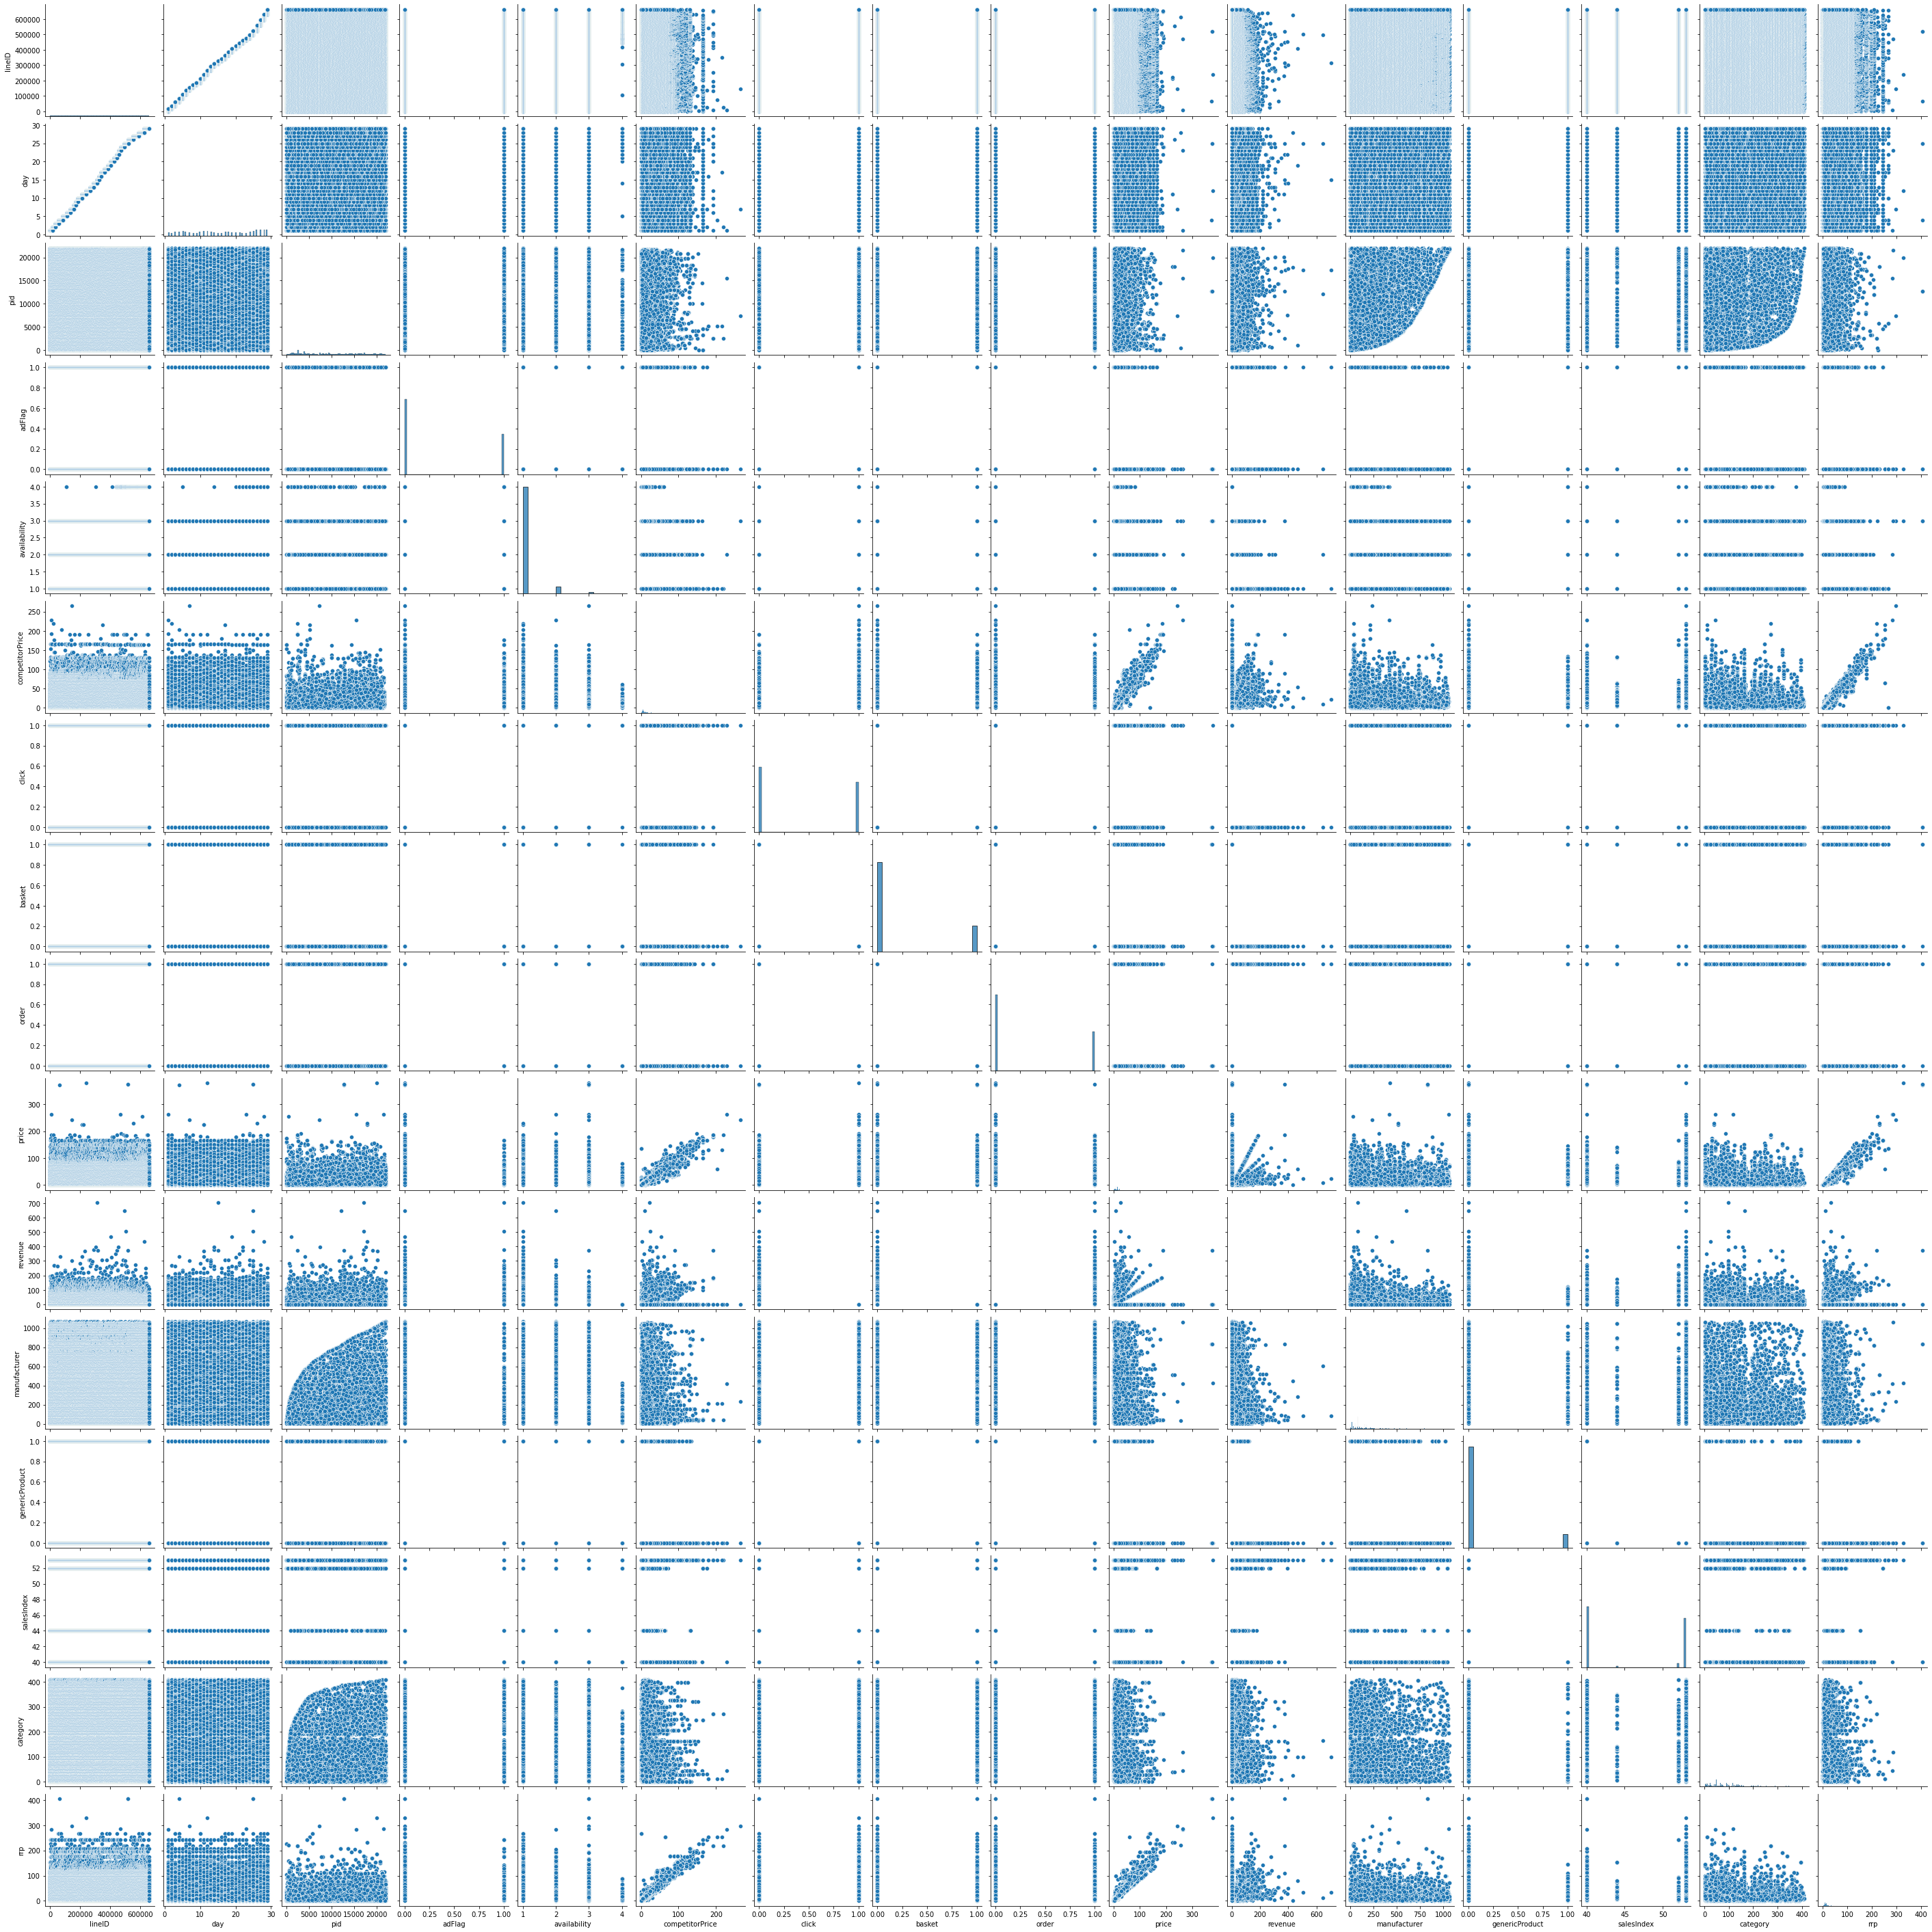

In [ ]:
sns.pairplot(train_df)

<AxesSubplot:ylabel='rrp'>

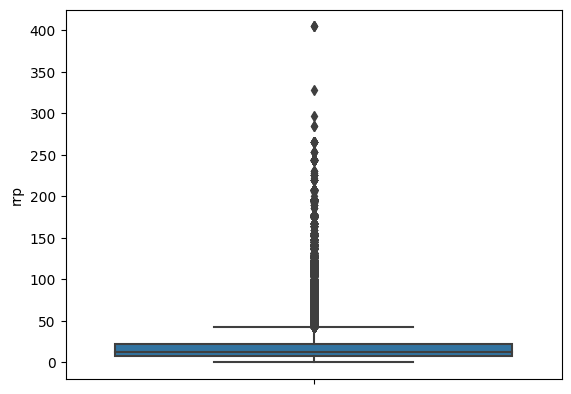

In [ ]:
sns.boxplot(y='rrp', data=train_df)

<AxesSubplot:ylabel='price'>

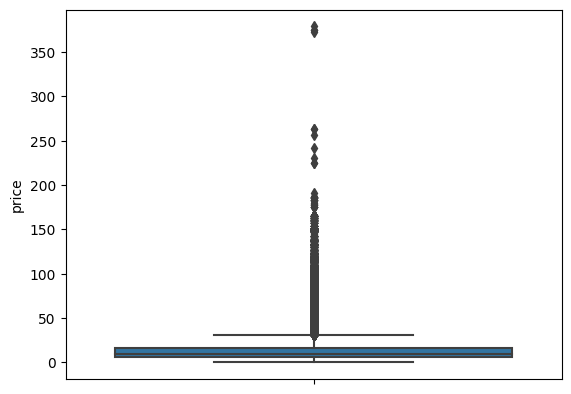

In [ ]:
sns.boxplot(y='price', data=train_df)

<AxesSubplot:ylabel='revenue'>

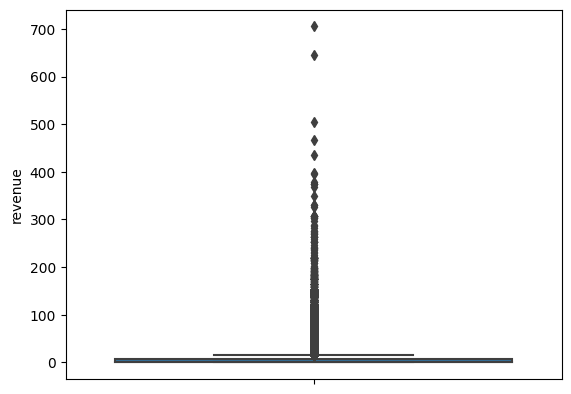

In [ ]:
sns.boxplot(y='revenue', data=train_df)

As we can see in the above boxplots, there are potential outliers for few attributes.

#### Product attributes that influences revenue

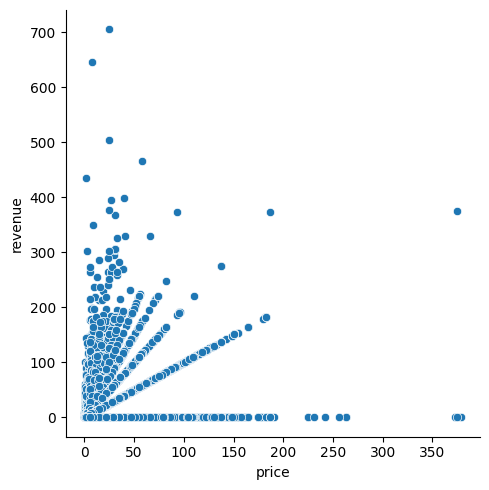

In [ ]:
sns.relplot(x='price', y='revenue',data=train_df)

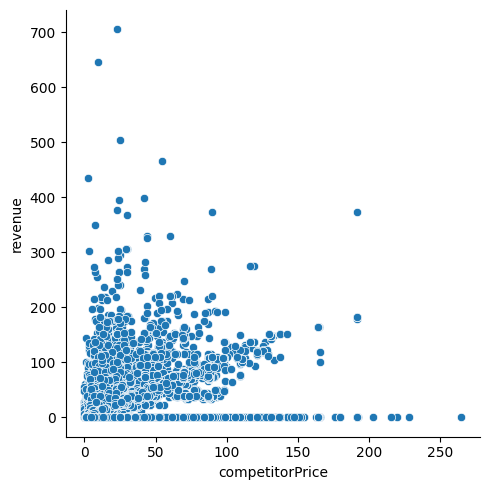

In [ ]:
sns.relplot(x='competitorPrice', y='revenue',data=train_df)

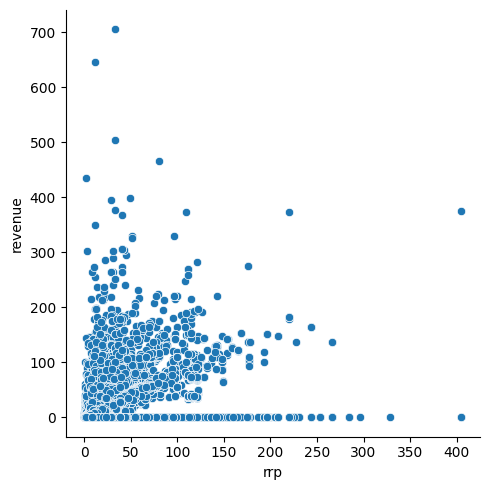

In [ ]:
sns.relplot(x='rrp', y='revenue',data=train_df)

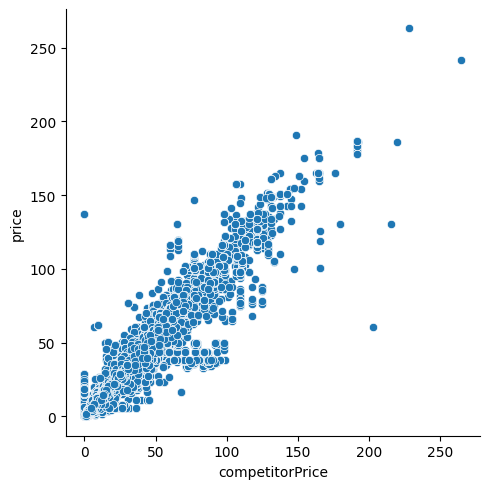

In [ ]:
sns.relplot(x='competitorPrice', y='price',data=train_df)

The above plots show the relationship between attributes.

In [ ]:
for x in train_df.columns:
    print(train_df[x].value_counts())   # To check unique values of each attribute

1         1
440939    1
440961    1
440962    1
440963    1
         ..
220483    1
220484    1
220485    1
220486    1
661445    1
Name: lineID, Length: 661445, dtype: int64
27    35605
28    35426
26    34816
29    33785
12    27300
5     26520
11    26465
25    25389
6     25223
4     24833
3     24669
13    24415
10    24054
24    22623
18    22474
17    22079
14    21303
19    20947
7     19779
20    19434
21    18595
1     18358
2     17331
8     16868
15    15721
22    15045
9     14860
23    13980
16    13548
Name: day, dtype: int64
2655     16924
2491      4484
13156     4233
1037      3060
4070      2970
         ...  
6856         1
6519         1
11434        1
5824         1
283          1
Name: pid, Length: 20338, dtype: int64
0    431933
1    229512
Name: adFlag, dtype: int64
1    611328
2     40134
3      9316
4       667
Name: availability, dtype: int64
13.74     13888
7.69       6165
6.59       6061
5.38       5154
5.49       4912
          ...  
58.92         1
31.74

In [ ]:
train_df.describe().T   #For sanity checks

,count,mean,std,min,25%,50%,75%,max
lineID,661445.0,330723.000000,190942.868740,1.00,165362.00,330723.00,496084.00,661445.00
day,661445.0,15.829590,8.788414,1.00,8.00,16.00,24.00,29.00
pid,661445.0,10362.257122,6469.288404,1.00,4121.00,9718.00,16089.00,22035.00
adFlag,661445.0,0.346986,0.476012,0.00,0.00,0.00,1.00,1.00
availability,661445.0,1.091870,0.343000,1.00,1.00,1.00,1.00,4.00
competitorPrice,638140.0,12.065005,11.769037,0.00,5.27,8.76,14.51,264.59
click,661445.0,0.435370,0.495806,0.00,0.00,0.00,1.00,1.00
basket,661445.0,0.225573,0.417959,0.00,0.00,0.00,0.00,1.00
order,661445.0,0.339058,0.473390,0.00,0.00,0.00,1.00,1.00
price,661445.0,13.170834,12.730748,0.08,5.54,9.85,15.86,378.84


In [ ]:
train_df.describe(include='object')

,group,content,unit,pharmForm,campaignIndex
count,661445,661445,661445,615922,132844
unique,530,530,8,271,3
top,22OI3,50,ST,TAB,B
freq,39840,98388,309990,61181,64138


#### Handling Null Values

In [ ]:
train_df.isna().sum()

lineID                  0
day                     0
pid                     0
adFlag                  0
availability            0
competitorPrice     23305
click                   0
basket                  0
order                   0
price                   0
revenue                 0
manufacturer            0
group                   0
content                 0
unit                    0
pharmForm           45523
genericProduct          0
salesIndex              0
category            21674
campaignIndex      528601
rrp                     0
dtype: int64

In [ ]:
train_df.isnull().sum()/train_df.shape[0]*100

lineID              0.000000
day                 0.000000
pid                 0.000000
adFlag              0.000000
availability        0.000000
competitorPrice     3.523347
click               0.000000
basket              0.000000
order               0.000000
price               0.000000
revenue             0.000000
manufacturer        0.000000
group               0.000000
content             0.000000
unit                0.000000
pharmForm           6.882356
genericProduct      0.000000
salesIndex          0.000000
category            3.276765
campaignIndex      79.916093
rrp                 0.000000
dtype: float64

In [ ]:
train_df['campaignIndex'] = train_df['campaignIndex'].fillna('UNKNOWN')
train_df['category'] = train_df['category'].fillna('UNKNOWN')
train_df['pharmForm'] = train_df['pharmForm'].fillna('UNKNOWN')

In [ ]:
train_df.isnull().sum()/train_df.shape[0]*100

lineID             0.000000
day                0.000000
pid                0.000000
adFlag             0.000000
availability       0.000000
competitorPrice    3.523347
click              0.000000
basket             0.000000
order              0.000000
price              0.000000
revenue            0.000000
manufacturer       0.000000
group              0.000000
content            0.000000
unit               0.000000
pharmForm          0.000000
genericProduct     0.000000
salesIndex         0.000000
category           0.000000
campaignIndex      0.000000
rrp                0.000000
dtype: float64

In [ ]:
train_df.shape

(661445, 21)

In [ ]:
##delete unnecessary columns

cols = ['pid', 'lineID', 'day']  

for col_name in cols:
    train_df.drop(col_name, inplace=True, axis=1)

# Data Transformation

#### Avoid curse of dimensionality

An increase in the dimensionality of the dataset causes curse of dimensionality, which leads to the problem of parallelism and multicollinearity. Hence, we have chosen to avoid one hot encoding for categorical columns with 10+ groups.

In [ ]:
'''Tried to choose top 15 columns to perform one hot encoding. But this will be unrealsitic to perform for columns with 100+ unique groups'''
# cols = ['group', 'content', 'unit', 'manufacturer','salesIndex', 'pharmForm', 'category']
# for col_name in cols:
#   top_15 = [x for x in train_df[col_name].value_counts().sort_values(ascending=False).head(30).index]
#   for label in top_15:
#     train_df[label] = np.where(train_df[col_name]==label,1,0)  

'Tried to choose top 15 columns to perform one hot encoding. But this will be unrealsitic to perform for columns with 100+ unique groups'

We have performed **Frequency Encoding** for few categorical columns

In [ ]:
cols = ['group', 'content', 'unit', 'manufacturer', 'pharmForm', 'category']
for col_name in cols:
  # grouping by frequency
  fq = train_df.groupby(col_name).size()/len(train_df)
  # mapping values to dataframe
  train_df.loc[:, "{}_freq_encoded".format(col_name)] = train_df[col_name].map(fq)
  # drop original column.
  train_df = train_df.drop([col_name], axis=1)
train_df.head(10)

,adFlag,availability,competitorPrice,click,basket,order,price,revenue,genericProduct,salesIndex,campaignIndex,rrp,group_freq_encoded,content_freq_encoded,unit_freq_encoded,manufacturer_freq_encoded,pharmForm_freq_encoded,category_freq_encoded
0,0,2,14.60,1,0,0,16.89,0.00,0,40,UNKNOWN,18.25,0.049838,0.148747,0.349399,0.005196,0.015102,0.003086
1,1,1,8.57,0,1,0,8.75,0.00,1,40,C,18.81,0.003152,0.148747,0.468656,0.046873,0.092496,0.028501
2,0,1,14.77,0,1,0,16.06,0.00,0,53,UNKNOWN,18.48,0.003320,0.001388,0.349399,0.012399,0.005840,0.003881
3,1,1,6.59,0,0,1,6.55,6.55,0,40,UNKNOWN,9.31,0.015847,0.027549,0.174535,0.044391,0.062634,0.022563
4,0,1,4.39,0,0,1,4.14,4.14,0,53,UNKNOWN,8.13,0.002560,0.000884,0.468656,0.009547,0.004280,0.001312
5,0,1,13.66,0,0,1,10.03,10.03,0,52,UNKNOWN,21.60,0.003565,0.003845,0.349399,0.009547,0.043165,0.002097
6,1,1,3.03,0,0,1,3.58,3.58,0,40,UNKNOWN,5.62,0.010595,0.119591,0.174535,0.056759,0.034709,0.023893
7,0,1,8.78,1,0,0,8.75,0.00,0,53,UNKNOWN,11.62,0.060232,0.120066,0.349399,0.019879,0.034709,0.013031
8,0,1,10.84,1,0,0,12.04,0.00,0,53,UNKNOWN,14.19,0.060232,0.148747,0.349399,0.000324,0.076062,0.013031
9,1,1,9.12,1,0,0,8.75,0.00,0,40,UNKNOWN,14.25,0.003628,0.120066,0.174535,0.002569,0.034709,0.023893


In [ ]:
y = train_df.pop('revenue')

#### **Pipeline for scaling and column transformation**

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (RobustScaler, MinMaxScaler, 
                                   MaxAbsScaler, QuantileTransformer,
                                   FunctionTransformer, OneHotEncoder, StandardScaler)
from scipy.sparse import csc_matrix
import sklearn
sklearn.set_config(display="diagram")

encoded_columns = ['group_freq_encoded', 'content_freq_encoded', 'unit_freq_encoded', 'manufacturer_freq_encoded', 'pharmForm_freq_encoded', 'category_freq_encoded']

ct = make_column_transformer(
        (
            OneHotEncoder(), 
            ['salesIndex','campaignIndex','availability']
        ),
        (
          make_pipeline(KNNImputer(), RobustScaler()), ['competitorPrice']
        ),
        (
          make_pipeline(RobustScaler()),
          ['price', 'rrp']
        ),
        (
        StandardScaler(), 
          ['availability', 'group_freq_encoded', 'content_freq_encoded', 'unit_freq_encoded', 'manufacturer_freq_encoded', 'pharmForm_freq_encoded', 'category_freq_encoded']

        ),
    remainder="passthrough"
)



In [ ]:
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['salesIndex', 'campaignIndex',
                                  'availability']),
                                ('pipeline-1',
                                 Pipeline(steps=[('knnimputer', KNNImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['competitorPrice']),
                                ('pipeline-2',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler())]),
                                 ['price', 'rrp']),
                                ('standardscaler', StandardScaler(),
                                 ['availability', 'group_freq_encoded',
                                  'content_freq_encoded', 'unit_freq_encoded',
                                  'manufacturer_freq_encoded',
                                  'pharmForm_freq_encoded',
                                  'category_freq_encoded'])])

In [ ]:
X = ct.fit_transform(train_df)

In [ ]:
X.shape

(661445, 27)

In [ ]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

- We have faced memory(RAM) issues, here we are releasing the pointer so that the garbage collector collects unused memory.

In [ ]:
X=[]

In [ ]:
print(X_train.shape,X_val.shape,X_test.shape)

(423324, 27) (105832, 27) (132289, 27)


In [ ]:
print(y_train.shape,y_val.shape,y_test.shape)

(423324,) (105832,) (132289,)


## Model Building

Models from multiple families like Linear Regression, Trees and KNN are applied to the dataset. The models with best accuracy are further chosen to perform hyper parameter tuning and model evaluation.

In [ ]:
estimators = {
    "lr": LinearRegression(),
    "ridge":Ridge(),
    "lasso":Lasso(),
    "knn":KNeighborsRegressor(),
    "dtree":DecisionTreeRegressor(),
    "adaBoost":AdaBoostRegressor(),
    "randomforest": RandomForestRegressor(),
    "xgb": xgb.XGBRegressor()
}

In [ ]:
cv_results = {}
for nm, est in estimators.items():
    print("model is ",nm)
    cv_results[nm] = cross_validate(est, X_train, y_train, 
                                return_estimator=True, 
                                cv=5,
                                verbose=5,
                                n_jobs=-1)

model is  lr


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.4s remaining:    3.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


model is  ridge


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


model is  lasso


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


model is  knn
[CV] END ......................................., score=0.452 total time=   0.4s
[CV] END ......................................., score=0.481 total time=   0.1s
[CV] END ......................................., score=0.485 total time=   0.3s
[CV] END ......................................., score=0.452 total time=   0.1s
[CV] END ......................................., score=0.481 total time=   0.3s
[CV] END ......................................., score=0.437 total time=   0.4s
[CV] END ......................................., score=0.481 total time=   0.3s
[CV] END ......................................., score=0.440 total time=   0.4s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  8.7min remaining: 13.0min


model is  dtree


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  8.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.0s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


model is  adaBoost


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.7s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


model is  randomforest
[CV] END ......................................., score=0.515 total time=   4.0s
[CV] END ......................................., score=0.759 total time=  47.5s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   48.6s remaining:  1.2min


[CV] END ......................................., score=0.307 total time=   3.3s
[CV] END ......................................., score=0.756 total time=  47.7s
[CV] END ......................................., score=0.717 total time= 8.7min
[CV] END ......................................., score=0.708 total time=   0.8s
[CV] END ......................................., score=0.721 total time=  48.2s
[CV] END ......................................., score=0.484 total time=   0.4s
[CV] END ......................................., score=0.484 total time=   0.1s
[CV] END ......................................., score=0.436 total time=   0.4s
[CV] END ......................................., score=0.718 total time= 8.2min
[CV] END ......................................., score=0.719 total time=   0.8s
[CV] END ......................................., score=0.354 total time=   3.6s
[CV] END ......................................., score=0.734 total time=  48.2s
model is  xgb


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   49.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   45.3s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.2s finished


#### R2 score of the models

In [ ]:
{nm: np.mean(scr["test_score"]) for nm, scr in cv_results.items()}

{'lr': 0.47663633722933446,
 'ridge': 0.4766358153882839,
 'lasso': 0.4312964771416225,
 'knn': 0.708078215486331,
 'dtree': 0.691322032523065,
 'adaBoost': 0.466864389434964,
 'randomforest': 0.7464525772070493,
 'xgb': 0.7659135582554805}

[CV] END ......................................., score=0.481 total time=   0.1s
[CV] END ......................................., score=0.722 total time= 8.7min
[CV] END ......................................., score=0.672 total time=   0.8s
[CV] END ......................................., score=0.488 total time=   3.2s
[CV] END ......................................., score=0.735 total time=  45.0s
[CV] END ......................................., score=0.762 total time=  47.9s
[CV] END ......................................., score=0.776 total time=  45.2s
[CV] END ......................................., score=0.408 total time=   0.3s
[CV] END ......................................., score=0.707 total time= 8.7min
[CV] END ......................................., score=0.663 total time=   0.8s
[CV] END ......................................., score=0.671 total time=   3.6s
[CV] END ......................................., score=0.778 total time=  45.4s
[CV] END ...................

The **Random Forest** and **XGBoost Regressor** models outperformed among all the models with R2 score of around 75%. Hence, we have applied hyperparameter tuning for both the models.

#### Hyperparameter Tuning for XGBoost and Random Forest Regressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

parameters_dict = { 
            'max_depth': [ 3, 6, 10, 15],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100, 300, 500, 1000],
            'colsample_bytree': [0.3, 0.8]}

xgb_regressor = xgb.XGBRegressor(seed = 42)

clf = RandomizedSearchCV(estimator=xgb_regressor,
                         param_distributions=parameters_dict,
                         scoring='neg_mean_squared_error',
                         n_iter=15,
                         verbose=5,
                        n_jobs=-1)

clf.fit(X_train, y_train)

print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 3/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=1000;, score=-30.370 total time= 1.9min
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, n_estimators=100;, score=-45.535 total time= 2.3min
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=300;, score=-28.205 total time=  34.5s
[CV 1/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=100;, score=-73.775 total time=  12.7s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, n_estimators=1000;, score=-37.546 total time=22.6min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.01, max_depth=3, n_estimators=1000;, score=-30.594 total time= 1.9min
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, max_depth=15, n_estimators=100;, score=-44.737 total time= 2.3min
[CV 5/5] END colsample_bytree=0.3, learning_rate=0.1, max_depth=3, n_estimators=300;, score=-2

#### Hyper Parameter Tuning for RandomForest Model

In [ ]:
param_grid = {
    "n_estimators":[50,300,500],
    "max_depth":[10, 50, 100],
    "max_features":[6,8,10,12,14,16,18]
}

random_forest_regressor = RandomForestRegressor()

random_forest_regressor = GridSearchCV(estimator=random_forest_regressor,
                            param_grid=param_grid,
                            cv=3,
                            n_jobs=-1,
                            verbose=2)

random_forest_regressor.fit(X_train, y_train)

random_forest_regressor.best_estimator_

Fitting 3 folds for each of 63 candidates, totalling 189 fits
[CV] END ......max_depth=10, max_features=6, n_estimators=50; total time=   7.4s
[CV] END ......max_depth=10, max_features=8, n_estimators=50; total time=   8.1s
[CV] END .....max_depth=10, max_features=8, n_estimators=300; total time=  54.0s
[CV] END ....max_depth=10, max_features=10, n_estimators=300; total time= 1.0min
[CV] END ....max_depth=10, max_features=12, n_estimators=500; total time= 1.8min
[CV] END ....max_depth=10, max_features=16, n_estimators=300; total time= 1.3min
[CV] END ......max_depth=50, max_features=6, n_estimators=50; total time=   9.9s
[CV] END ......max_depth=50, max_features=6, n_estimators=50; total time=   9.6s
[CV] END ......max_depth=50, max_features=6, n_estimators=50; total time=   9.7s
[CV] END .....max_depth=50, max_features=6, n_estimators=300; total time=  58.6s


/Users/abobbill/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......max_depth=10, max_features=6, n_estimators=50; total time=   7.6s
[CV] END .....max_depth=10, max_features=8, n_estimators=300; total time=  54.6s
[CV] END .....max_depth=10, max_features=10, n_estimators=50; total time=  10.9s
[CV] END ....max_depth=10, max_features=10, n_estimators=500; total time= 1.7min
[CV] END ....max_depth=10, max_features=14, n_estimators=300; total time= 1.2min
[CV] END .....max_depth=10, max_features=18, n_estimators=50; total time=  14.8s
[CV] END .....max_depth=10, max_features=18, n_estimators=50; total time=  14.0s
[CV] END .....max_depth=10, max_features=18, n_estimators=50; total time=  13.7s
[CV] END ....max_depth=10, max_features=18, n_estimators=300; total time= 1.4min
[CV] END .....max_depth=50, max_features=6, n_estimators=300; total time=  57.5s
[CV] END .....max_depth=10, max_features=6, n_estimators=300; total time=  44.6s
[CV] END .....max_depth=10, max_features=8, n_estimators=500; total time= 1.5min
[CV] END .....max_depth=10, 

RandomForestRegressor(max_depth=10, max_features=10, n_estimators=500)

[CV] END ...max_depth=100, max_features=16, n_estimators=300; total time= 1.7min
[CV] END ...max_depth=100, max_features=16, n_estimators=500; total time= 2.8min
[CV] END ...max_depth=100, max_features=12, n_estimators=500; total time= 2.3min
[CV] END ....max_depth=100, max_features=18, n_estimators=50; total time=  19.5s
[CV] END ....max_depth=100, max_features=18, n_estimators=50; total time=  19.8s
[CV] END ....max_depth=100, max_features=18, n_estimators=50; total time=  19.0s
[CV] END ...max_depth=100, max_features=18, n_estimators=300; total time= 1.7min
[CV] END ...max_depth=100, max_features=18, n_estimators=300; total time= 1.7min
[CV] END ...max_depth=100, max_features=18, n_estimators=300; total time= 1.8min
[CV] END ...max_depth=100, max_features=18, n_estimators=500; total time= 2.6min


In [ ]:
random_forest_regressor.best_estimator_

RandomForestRegressor(max_depth=10, max_features=10, n_estimators=500)

#### Training XGBRegressor and Random Forest models with best parameters

In [ ]:
xgb_model=xgb.XGBRegressor(n_estimators=100, max_depth= 6, learning_rate=0.1, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [ ]:
# Training Score of XGB model
xgb_model.score(X_train, y_train)

0.7865990581307345

In [ ]:
# Training Score of Random Forest model
random_forest_model=RandomForestRegressor(max_depth=10, max_features=10, n_estimators=500)

In [ ]:
random_forest_model.fit(X_train, y_train)

random_forest_model.score(X_train, y_train)

The R2 score on training set for both XGB and Random Forest are 78.6% and 78.8% respectively.

#### XGBoost with Early Stopping and evaluation metric RMSE

In [ ]:
eval_set = [(X_train,y_train),(X_val,y_val)]
xgb_model=xgb.XGBRegressor(n_estimators=100, max_depth= 6, learning_rate=0.1, colsample_bytree=0.8)
xgb_model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric=['rmse'], eval_set=eval_set, verbose=True)

/Users/abobbill/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/abobbill/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:11.18164	validation_1-rmse:10.99012
[1]	validation_0-rmse:10.35126	validation_1-rmse:10.15388
[2]	validation_0-rmse:9.62675	validation_1-rmse:9.42230
[3]	validation_0-rmse:8.99476	validation_1-rmse:8.78520
[4]	validation_0-rmse:8.44587	validation_1-rmse:8.23238
[5]	validation_0-rmse:7.97917	validation_1-rmse:7.76173
[6]	validation_0-rmse:7.57734	validation_1-rmse:7.35599
[7]	validation_0-rmse:7.22953	validation_1-rmse:7.00402
[8]	validation_0-rmse:6.94322	validation_1-rmse:6.71420
[9]	validation_0-rmse:6.69378	validation_1-rmse:6.45903
[10]	validation_0-rmse:6.48324	validation_1-rmse:6.24555
[11]	validation_0-rmse:6.41994	validation_1-rmse:6.18310
[12]	validation_0-rmse:6.25385	validation_1-rmse:6.01391
[13]	validation_0-rmse:6.11827	validation_1-rmse:5.87490
[14]	validation_0-rmse:6.00018	validation_1-rmse:5.75825
[15]	validation_0-rmse:5.90288	validation_1-rmse:5.66157
[16]	validation_0-rmse:5.81996	validation_1-rmse:5.58286
[17]	validation_0-rmse:5.75041	valida

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
xgb_model.score(X_train, y_train)

0.7855953957972346

# Model Evaluation

### Evaluation on validation sets

In [ ]:
# Validation Score of XGB model
y_pred=xgb_model.predict(X_val)
r2_score(y_val, y_pred)

0.7844886930868937

In [ ]:
# Random forest model validation score
y_pred=random_forest_model.predict(X_val)
r2_score(y_val, y_pred)

0.7827137696581268

The R2 score on validation set for both XGB and Random Forest are 78.4% and 78.3% respectively.

### Learning curves

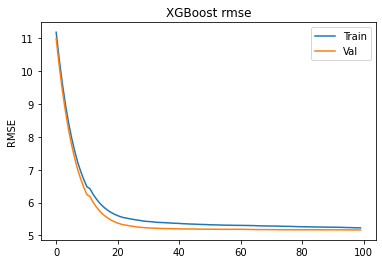

In [ ]:
import matplotlib.pyplot as plt

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')

ax.legend()

plt.ylabel('RMSE')
plt.title('XGBoost rmse')

plt.show()

The above learning curve explains that the XGB model is a good fit as both training and validation sets are performing better on the dataset.

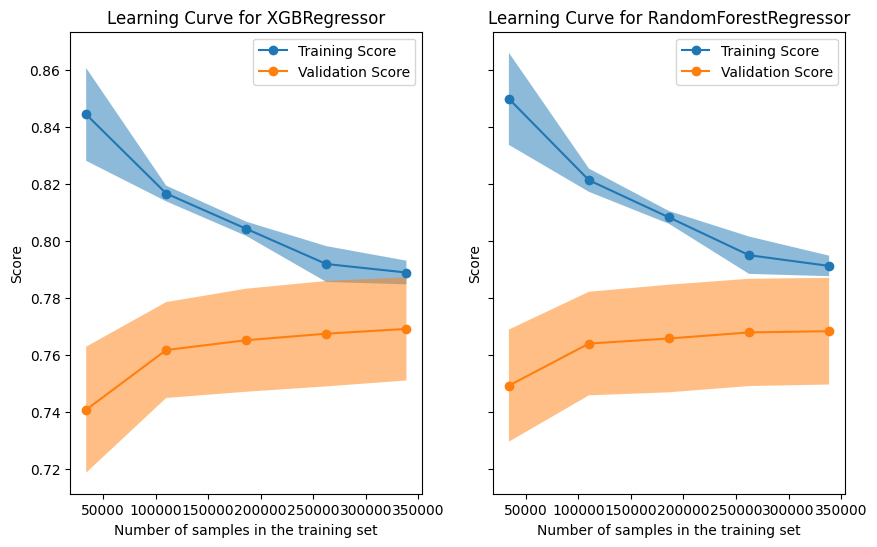

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

xgb_model=xgb.XGBRegressor(n_estimators=100, max_depth= 6, learning_rate=0.1, colsample_bytree=0.8)
random_forest_model=RandomForestRegressor(max_depth=10, max_features=10, n_estimators=500)

common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
}

for ax_idx, estimator in enumerate([xgb_model, random_forest_model]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Validation Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

As we can see from the above Learning curves, 
- The training and validation curves are not yet converged which means the model is neither overfit nor underfit.
- Even though the R2 value decreases for the training data, the test score is increasing with the number of data points. This suggests that having more data points would improve the score on test data.


# Predictive Validity

In [ ]:
y_pred=random_forest_model.predict(X_test)
r2_score(y_test, y_pred)

0.7755706000789917

In [ ]:
y_pred=xgb_model.predict(X_test)
r2_score(y_test, y_pred)

0.7755679129134717

Both the models are giving an R2 score of 77% on the Test dataset which is comparable to the training and validation sets.

# References

https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
